In [79]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import json
import random
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Flatten, InputLayer, LSTM, Dropout, BatchNormalization, Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping
from keras import backend as K

In [80]:
# Read in emission data
emission_input = pd.read_csv('../../../data/greenhouse_emissions/oeko-institut_sektorale_abgrenzung_treibhausgasemissionen_daten_sektor_monthly.csv')
emission_data = emission_input['M_Mio.tonnes_CO2'].values
emission_data = emission_data[0:len(emission_data)-6]
emission_data = emission_data.astype('float64')
emission_index = emission_input['date'].values
emission_index = emission_index[0:len(emission_index)-6]
# Take only the emissions on which we have indicators
print(f"Shape output data: {emission_data.shape}")
#print(emission_index)
#print(emission_index)

Shape output data: (366,)


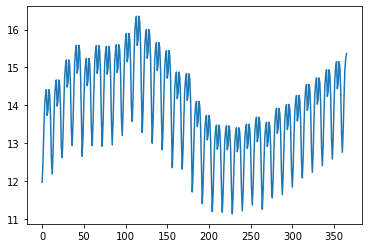

In [81]:
plt.plot(emission_data)

In [82]:
emission_input_mapping = pd.read_csv('mobilitydata.csv')
emission_data_NN = emission_input_mapping['NN'].values
emission_index_NN = emission_input_mapping['date'].values
print(emission_index_NN)
print(emission_data_NN)
print(f"Shape output data: {emission_data_NN.shape}")

['2018-01' '2018-02' '2018-03' '2018-04' '2018-05' '2018-06' '2018-07'
 '2018-08' '2018-09' '2018-10' '2018-11' '2018-12' '2019-01' '2019-02'
 '2019-03' '2019-04' '2019-05' '2019-06' '2019-07' '2019-08' '2019-09'
 '2019-10' '2019-11' '2019-12' '2020-01' '2020-02' '2020-03' '2020-04'
 '2020-05' '2020-06']
[12.800821  12.620186  13.654676  13.651155  14.066891  14.237059
 14.724207  14.409109  14.377022  14.6279335 13.547993  12.66835
 13.020998  12.912552  13.80438   13.903673  14.292274  14.057856
 14.811386  14.308575  14.421654  14.539726  13.252577  12.651304
 12.85627   12.790567  11.2270355  8.352516   9.318432   9.928791 ]
Shape output data: (30,)


In [83]:
#Combine Mapping of NN and data from oeko institute
emission_data_combined = emission_data
emission_data_combined[len(emission_data)-30:len(emission_data)] = emission_data_NN
print(emission_data_combined)

[11.9653861  12.50926729 13.32508907 14.00494055 14.27688115 14.41285144
 13.73299996 13.86897026 14.41285144 14.27688115 13.73299996 12.64523759
 12.17846069 12.73202709 13.56237668 14.25433467 14.53111787 14.66950947
 13.97755148 14.11594308 14.66950947 14.53111787 13.97755148 12.87041869
 12.61736841 13.19088516 14.05116028 14.76805621 15.05481458 15.19819377
 14.48129784 14.62467702 15.19819377 15.05481458 14.48129784 13.33426434
 12.93823762 13.52633933 14.4084919  15.14361904 15.43766989 15.58469532
 14.84956818 14.99659361 15.58469532 15.43766989 14.84956818 13.67336476
 12.65083965 13.22587782 14.08843507 14.80723278 15.09475186 15.2385114
 14.51971369 14.66347323 15.2385114  15.09475186 14.51971369 13.36963736
 12.93193944 13.51975487 14.40147801 15.1362473  15.43015501 15.57710887
 14.84233958 14.98929344 15.57710887 15.43015501 14.84233958 13.66670872
 12.9145444  13.50156914 14.38210626 15.11588719 15.40939956 15.55615575
 14.82237482 14.969131   15.55615575 15.40939956 14.

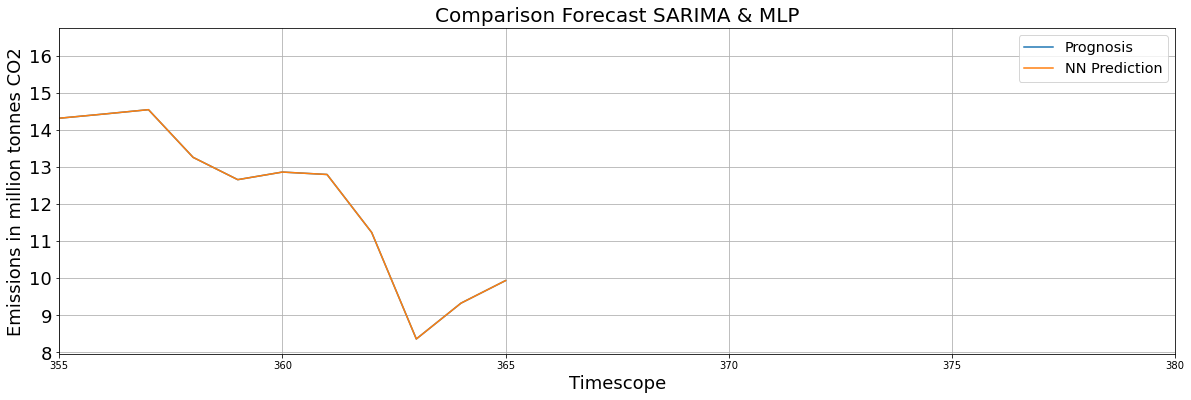

In [84]:
plt.figure(figsize=(20,6))
line1 = plt.plot(emission_data, label='Prognosis')
line2 = plt.plot(emission_data_combined, label='NN Prediction')

plt.legend(fontsize='x-large')
plt.grid()
#plt.xticks(np.arange(6), ['2020-07','2020-08', '2020-09', '2020-10', '2020-11', '2020-12'], rotation=30, fontsize=16)
plt.xlim([355,380])


plt.xlabel("Timescope", fontsize=18)
plt.ylabel("Emissions in million tonnes CO2", fontsize=18)
plt.yticks(fontsize=18)
plt.title("Comparison Forecast SARIMA & MLP", fontsize=20)
plt.show()

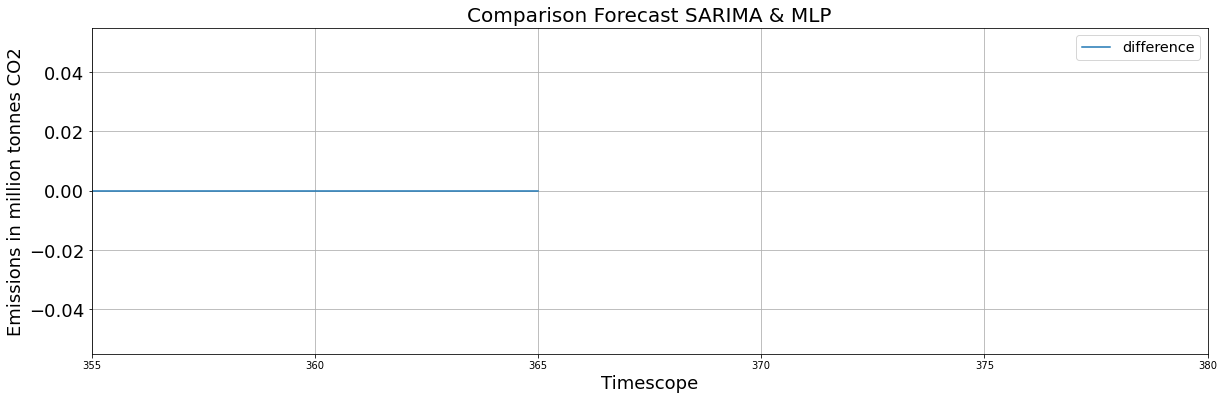

In [85]:
plt.figure(figsize=(20,6))
difference = emission_data_combined - emission_data
#line1 = plt.plot(emission_data, label='Prognosis')
line2 = plt.plot(difference, label='difference')

plt.legend(fontsize='x-large')
plt.grid()
#plt.xticks(np.arange(6), ['2020-07','2020-08', '2020-09', '2020-10', '2020-11', '2020-12'], rotation=30, fontsize=16)
plt.xlim([355,380])


plt.xlabel("Timescope", fontsize=18)
plt.ylabel("Emissions in million tonnes CO2", fontsize=18)
plt.yticks(fontsize=18)
plt.title("Comparison Forecast SARIMA & MLP", fontsize=20)
plt.show()

In [86]:
data= pd.Series(emission_data)
first_date = emission_index[0]
last_date = emission_index[-1]
split_train = np.arange(0, len(data))
split_test = np.arange((len(data)), len(data))
train_data = pd.Series(data, index=split_train)
test_data = pd.Series(data, index=split_test)
time_scope = emission_index

In [87]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train_data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=21.896, BIC=41.228, Time=3.645 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=40.324, BIC=48.057, Time=0.088 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=27.444, BIC=42.910, Time=1.641 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=22.200, BIC=37.666, Time=1.793 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=39.146, BIC=43.012, Time=0.132 seconds
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=21.970, BIC=37.436, Time=0.456 seconds
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=22.351, BIC=45.550, Time=6.685 seconds
Fit ARIMA(1,1,1)x(0,1,2,12) [intercept=True]; AIC=18.256, BIC=41.455, Time=9.566 seconds
Fit ARIMA(1,1,1)x(1,1,2,12) [intercept=True]; AIC=20.002, BIC=47.068, Time=16.694 seconds
Fit ARIMA(0,1,1)x(0,1,2,12) [intercept=True]; AIC=19.102, BIC=38.434, Time=6.907 seconds
Fit ARIMA(1,1,0)x(0,1,2,12) [intercept=True]; AIC=23.448, BIC=42.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  366
Model:             SARIMAX(3, 1, 2)x(0, 1, 2, 12)   Log Likelihood                   8.354
Date:                            Mon, 17 Aug 2020   AIC                              1.292
Time:                                    22:33:14   BIC                             36.090
Sample:                                         0   HQIC                            15.138
                                            - 366                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0109      0.017     -0.643      0.520      -0.044       0.022
ar.L1          1.2271      0.043     28.605      0.000       1.143       1.311
ar.L2         -1.2135      0.029    -41.698      0.000      -1.271      -1.156
ar.L3          0.2222      0.036      6.116      0.000       0.151       0.293
ma.L1         -1.0817      0.063    -17.257      0.000      -1.205      -0.959
ma.L2          0.9271      0.046     20.175      0.000       0.837       1.017
ma.S.L12      -0.2660      0.075     -3.556      0.000      -0.413      -0.119
ma.S.L24       0.2723      0.068      4.003      0.000       0.139       0.406
sigma2         0.0549      0.002     30.509      0.000       0.051       0.058
===================================================================================
Ljung-Box (Q):                       48.70   Jarque-Bera (JB):             40403.83
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):              11.59   Skew:                            -5.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        54.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

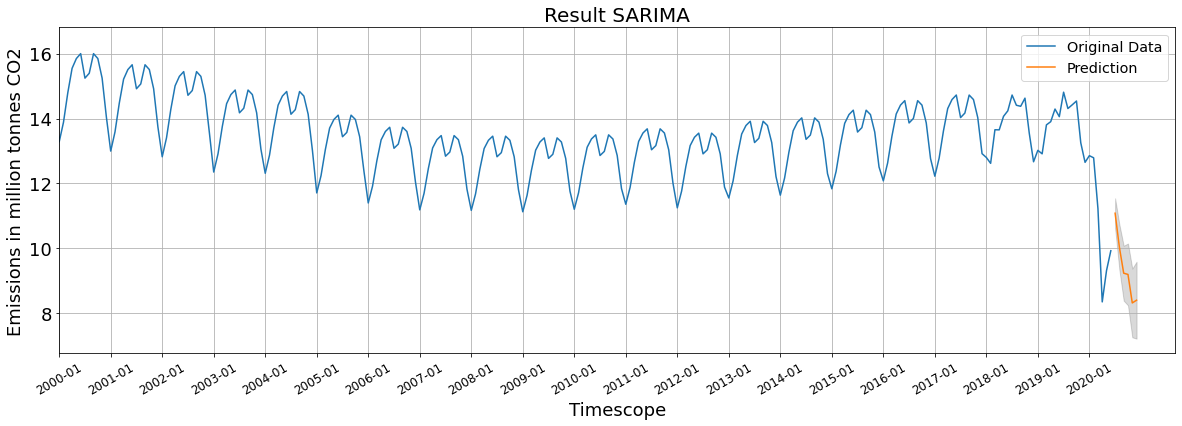

In [88]:
# Forecast
#to get accuracy predict last year as well
n_periods = 6
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
#index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')
#index_of_fc = np.arange(len(data)-12, len(data)-12+n_periods)

index_of_fc = np.arange(len(data), len(data)+n_periods)
#index_of_test = np.arange(len(data)-12, len(data))
index_of_compare = np.arange(0,5)

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)
sarima_array = fitted[-7:-1]
sarima_compare = pd.Series(sarima_array, index=index_of_compare)

# Plot baseline, training, test and forecast
plt.figure(figsize=(20,6))
line1 = plt.plot(train_data, label='Original Data')
line2 = plt.plot(fitted_series, label='Prediction')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.legend(fontsize='x-large')
plt.grid()
plt.xticks(np.arange(len(time_scope))[::12], time_scope[::12], rotation=30, fontsize=12)
#plt.xticks(np.arange(len(time_scope)), time_scope, rotation=30)
plt.xlim([120,380])
plt.xlabel("Timescope", fontsize=18)
plt.ylabel("Emissions in million tonnes CO2", fontsize=18)
plt.yticks(fontsize=18)
plt.title("Result SARIMA", fontsize=20)

plt.show()

In [89]:
# Convert an array of values into a dataset matrix
def sliding_window(input, output, look_back=1, horizon=1, shuffle=False):
	dataX, dataY = [], []
	if len(input) != len(output):
		raise ValueError('Input and ouput do not have same length!')
	for i in range(len(input)-look_back-horizon):
		dataX.append(input[i:(i+look_back)])
		dataY.append(output[(i+look_back):(i+look_back+horizon)])
	# Shuffle windows
	if shuffle is True:
		dataX, dataY = shuffle(dataX, dataY, random_state=0)
	return np.array(dataX), np.array(dataY)

In [90]:
from keras import backend as K

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [91]:
scaler = StandardScaler()
#emission_data = scaler.fit_transform(emission_data)

look_back = 12  # months
horizon = 6     # months
split_ratio = 0.8
shuffle = True

# Split into train and test sets
train_size = int(len(emission_data) * split_ratio)
test_size = len(emission_data) - train_size
if test_size < (look_back+horizon):
    raise ValueError('Split ratio too small. Increase test size!')

In [92]:
# Regressions forecast model with windowing method
def train_model(trainX, trainY, testX,  testY, lock_back, horizon):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)
    model = Sequential()
    # Flatten array if input is matrix
    if len(trainX.shape) >= 3:
        model.add(Flatten())
        model.add(Dense(look_back, input_dim=trainX.shape[2]*look_back, activation='relu'))
    model.add(Dense(24, input_dim=look_back, activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(horizon))
    model.compile(loss='mean_squared_error', optimizer='adam')#, metrics=[r2_keras])
    model.fit(trainX, trainY, epochs=100, batch_size=2, verbose=2, callbacks=[es])
    model.summary()
    # Estimate model performance
    trainScore = model.evaluate(trainX, trainY, verbose=0)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
    testScore = model.evaluate(testX, testY, verbose=0)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

    # Generate predictions for training
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    return model, trainPredict, testPredict

In [93]:
# Emissions as input
trainX, trainY = sliding_window(emission_data[0:train_size],
                                emission_data[0:train_size],
                                look_back,
                                horizon)
testX, testY = sliding_window(emission_data[train_size:len(emission_data)],
                              emission_data[train_size:len(emission_data)],
                              look_back,
                              horizon)

In [94]:
print("Shape of data:")
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

Shape of data:
(274, 12)
(274, 6)
(56, 12)
(56, 6)


In [95]:
# Create and fit Multilayer Perceptron model for every indicator
trainPredictPlot = np.empty_like(emission_data)
trainPredictPlot[:] = np.nan
testPredictPlot = np.empty_like(emission_data)
testPredictPlot[:] = np.nan

# Train model and generate predictions
model, trainPredict, testPredict = train_model(trainX, trainY, testX, testY, look_back, horizon)

# Shift train predictions for plotting
for t in range(len(trainPredict)):
    trainPredictPlot[t+look_back:t+look_back+horizon] = trainPredict[t, :]
for t in range(len(testPredict)):
    testPredictPlot[len(trainPredict)+t+look_back+horizon:len(trainPredict)+
                    t+look_back+(horizon*2)] = testPredict[t, :]

Epoch 1/100
137/137 - 0s - loss: 138.4473
Epoch 2/100
137/137 - 0s - loss: 1.2405
Epoch 3/100
137/137 - 0s - loss: 0.8235
Epoch 4/100
137/137 - 0s - loss: 0.8169
Epoch 5/100
137/137 - 0s - loss: 0.8196
Epoch 6/100
137/137 - 0s - loss: 0.8242
Epoch 7/100
137/137 - 0s - loss: 0.7962
Epoch 8/100
137/137 - 0s - loss: 0.7865
Epoch 9/100
137/137 - 0s - loss: 0.7626
Epoch 10/100
137/137 - 0s - loss: 0.7700
Epoch 11/100
137/137 - 0s - loss: 0.7453
Epoch 12/100
137/137 - 0s - loss: 0.7444
Epoch 13/100
137/137 - 0s - loss: 0.7184
Epoch 14/100
137/137 - 0s - loss: 0.7278
Epoch 15/100
137/137 - 0s - loss: 0.7000
Epoch 16/100
137/137 - 0s - loss: 0.7010
Epoch 17/100
137/137 - 0s - loss: 0.6668
Epoch 18/100
137/137 - 0s - loss: 0.6705
Epoch 19/100
137/137 - 0s - loss: 0.6570
Epoch 20/100
137/137 - 0s - loss: 0.6534
Epoch 21/100
137/137 - 0s - loss: 0.6092
Epoch 22/100
137/137 - 0s - loss: 0.6196
Epoch 23/100
137/137 - 0s - loss: 0.5795
Epoch 24/100
137/137 - 0s - loss: 0.5781
Epoch 25/100
137/137 - 

137/137 - 0s - loss: 0.2989
Epoch 53/100
137/137 - 0s - loss: 0.3061
Epoch 54/100
137/137 - 0s - loss: 0.2792
Epoch 55/100
137/137 - 0s - loss: 0.2992
Epoch 56/100
137/137 - 0s - loss: 0.2899
Epoch 57/100
137/137 - 0s - loss: 0.2829
Epoch 58/100
137/137 - 0s - loss: 0.2730
Epoch 59/100
137/137 - 0s - loss: 0.2654
Epoch 60/100
137/137 - 0s - loss: 0.2592
Epoch 61/100
137/137 - 0s - loss: 0.2394
Epoch 62/100
137/137 - 0s - loss: 0.2389
Epoch 63/100
137/137 - 0s - loss: 0.2323
Epoch 64/100
137/137 - 0s - loss: 0.2251
Epoch 65/100
137/137 - 0s - loss: 0.2234
Epoch 66/100
137/137 - 0s - loss: 0.2212
Epoch 67/100
137/137 - 0s - loss: 0.2106
Epoch 68/100
137/137 - 0s - loss: 0.2003
Epoch 69/100
137/137 - 0s - loss: 0.1876
Epoch 70/100
137/137 - 0s - loss: 0.1846
Epoch 71/100
137/137 - 0s - loss: 0.1804
Epoch 72/100
137/137 - 0s - loss: 0.1785
Epoch 73/100
137/137 - 0s - loss: 0.1636
Epoch 74/100
137/137 - 0s - loss: 0.1613
Epoch 75/100
137/137 - 0s - loss: 0.1674
Epoch 76/100
137/137 - 0s - l

Train Score: 0.13 MSE (0.36 RMSE)
Test Score: 0.46 MSE (0.68 RMSE)


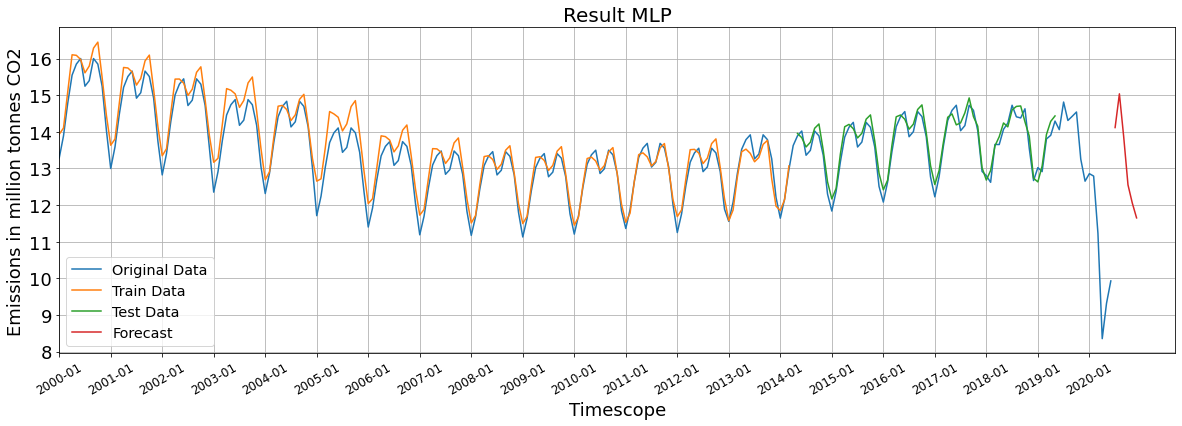

In [96]:
# Forecast predictions
forecastPlot = np.zeros((len(emission_data) + horizon))
forecastPlot[:] = np.nan
mlp_compare = np.zeros(6)

X = np.zeros((1, look_back))
X[0] = emission_data[len(emission_data)-look_back:]
predict = model.predict(X)
forecastPlot[len(emission_data):len(emission_data)+horizon] = predict[:]
mlp_compare[0:6] = predict[:]

# Plot baseline, training, test and forecast
plt.figure(figsize=(20,6))
line1 = plt.plot(emission_data[:], label='Original Data')
line3 = plt.plot(trainPredictPlot[:], label='Train Data')
line2 = plt.plot(testPredictPlot[:], label='Test Data')
line4 = plt.plot(forecastPlot[:], label='Forecast')

plt.legend(fontsize='x-large')
plt.grid()
plt.xticks(np.arange(len(time_scope)+1)[::12], time_scope[::12], rotation=30, fontsize=12)
plt.xlim([120,380])
plt.xlabel("Timescope", fontsize=18)
plt.ylabel("Emissions in million tonnes CO2", fontsize=18)
plt.yticks(fontsize=18)
plt.title("Result MLP", fontsize=20)
plt.show()

#plt.xticks(np.arange(len(time_scope)), time_scope, rotation=30)